## Load data and glimpse at it

In [1]:
import pandas as pd
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
import numpy as np


Helper function from exercise 5

In [2]:
def plot_confusion_matrix(
    cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()

In [3]:
# Load dataset
df = pd.read_csv("diabetes_prediction_dataset.csv")

### Univariate exploration

In [4]:
# show the first 5 rows
df.head()


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [5]:
# show data types of the dataset
df.dtypes


gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object

In [6]:
# show summary of the dataset
df.describe()


,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


#### Missings

In [7]:
missing_values_count = df.isna().sum()
print(missing_values_count)

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


#### Imbalenced classes

See how imbalance the data is

In [8]:
freq_table = df["diabetes"].value_counts()
print(freq_table)

0    91500
1     8500
Name: diabetes, dtype: int64


<Axes: xlabel='diabetes', ylabel='count'>

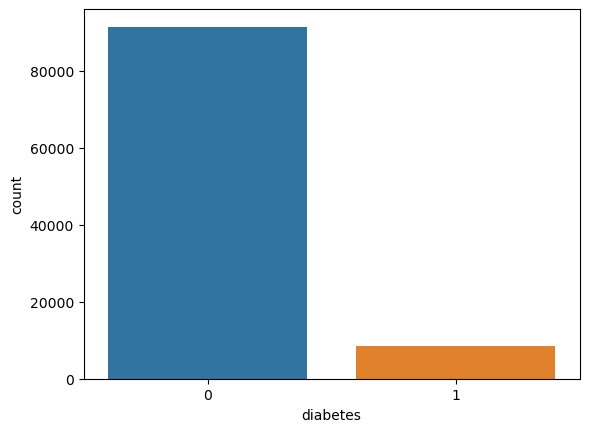

In [9]:
sns.countplot(data=df, x="diabetes")

### Bivariate exploration

/var/folders/72/sfv07sqs6yx02sknhjkgfkcm0000gn/T/ipykernel_29123/326357761.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


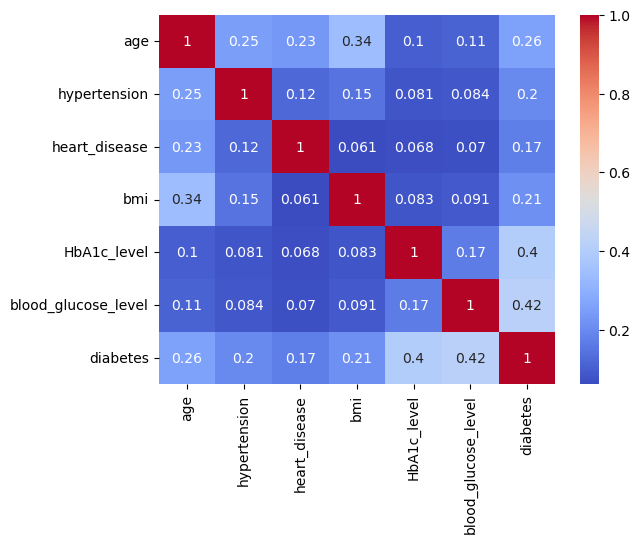

In [10]:
# compute the correlation matrix
corr_matrix = df.corr()

# plot the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

## Baseline

In [11]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_predict

In [12]:
numeric_features = [
    "age",
    "hypertension",
    "heart_disease",
    "bmi",
    "HbA1c_level",
    "blood_glucose_level",
]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
    ]
)

pipeline = Pipeline(
    [
        ("preprocessing", preprocessor),
        ("balancing", RandomOverSampler()),
        ("estimator", DecisionTreeClassifier(max_depth=7, random_state=42)),
    ]
)

# Prepare data
X = df.drop("diabetes", axis=1)
y = df["diabetes"]

# Prepare target labels
labeler = LabelEncoder()
labeler.fit(y)
y = labeler.transform(y)
label_names = ["Negative", "Positive"]
label_order = [0, 1]

# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [13]:
def run_baseline(estimator, X_train, X_test, y_train, y_test):
    # Train and predict
    pipeline.set_params(estimator=estimator)
    pipeline.fit(X_train, y_train)
    prediction = pipeline.predict(X_test)

    # Compute metrics
    cm = confusion_matrix(y_test, prediction, labels=label_order)

    # Plot 
    plot_confusion_matrix(cm, classes=label_names, title=type(estimator).__name__)
    plt.show()
    print(classification_report(y_test, prediction, target_names=label_names))

    

###  Decision Tree

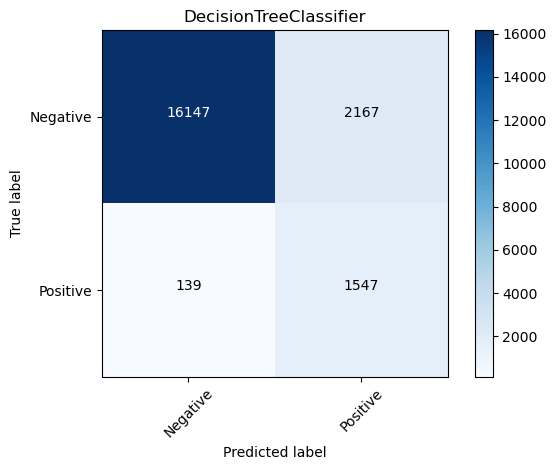

              precision    recall  f1-score   support

    Negative       0.99      0.88      0.93     18314
    Positive       0.42      0.92      0.57      1686

    accuracy                           0.88     20000
   macro avg       0.70      0.90      0.75     20000
weighted avg       0.94      0.88      0.90     20000



In [14]:
estimator = DecisionTreeClassifier(max_depth=7, random_state=42)
run_baseline(estimator, X_train, X_test, y_train, y_test)

#### Plot decision tree

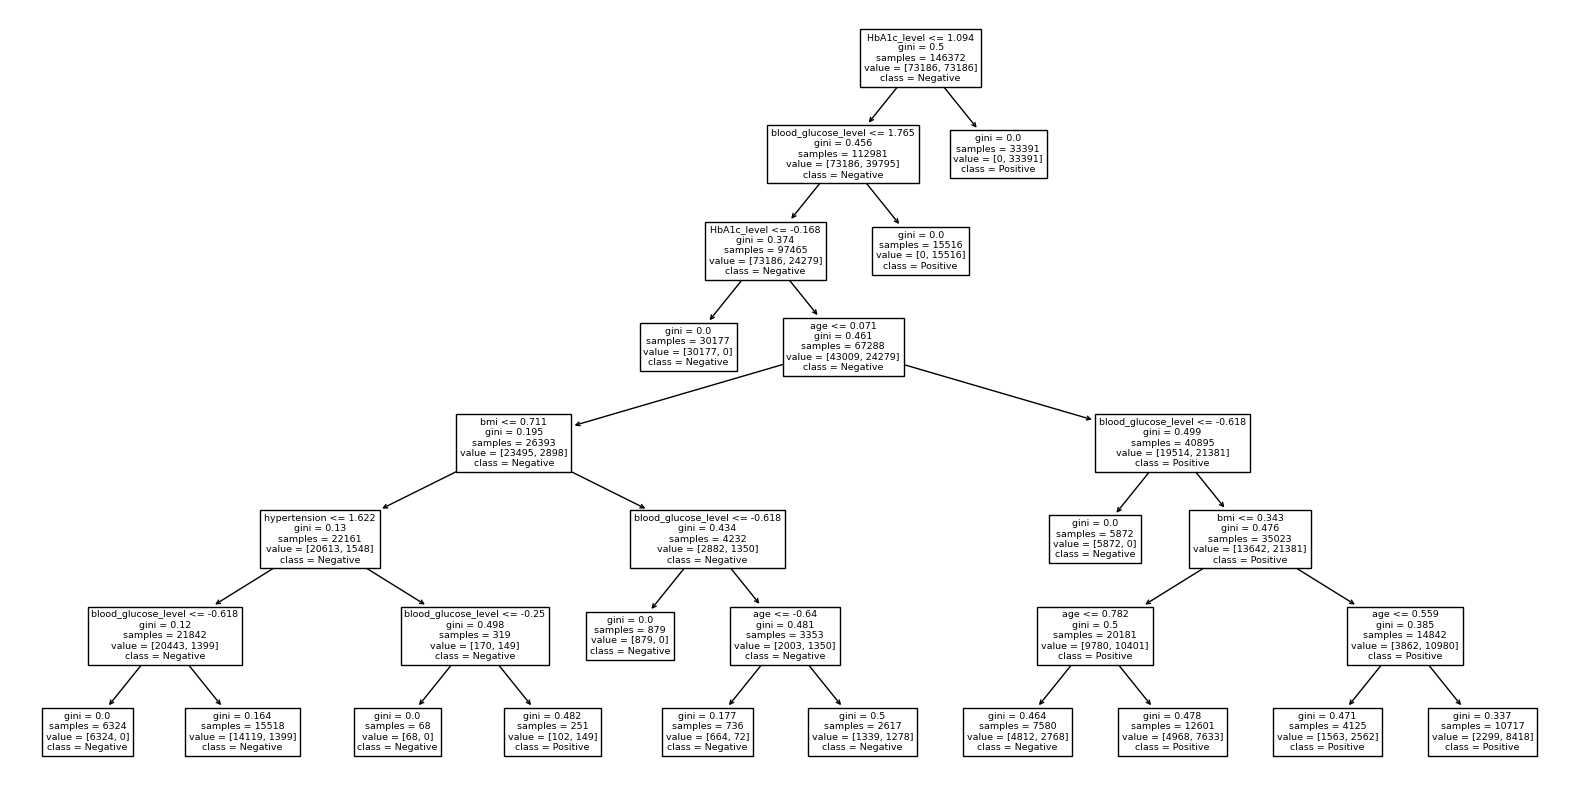

In [15]:
from sklearn import tree

plt.figure(figsize=(20, 10))
tree.plot_tree(estimator, feature_names=numeric_features, class_names=label_names)

plt.savefig("decision_tree.svg", dpi=350, format="svg")
plt.show()

#### Optimize hyperparameters

### Random Forest

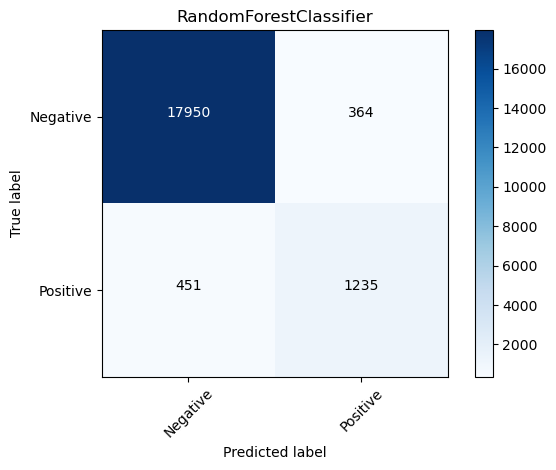

              precision    recall  f1-score   support

    Negative       0.98      0.98      0.98     18314
    Positive       0.77      0.73      0.75      1686

    accuracy                           0.96     20000
   macro avg       0.87      0.86      0.86     20000
weighted avg       0.96      0.96      0.96     20000



In [16]:
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(n_estimators=100, random_state=42)
run_baseline(estimator, X_train, X_test, y_train, y_test)

### K Nearest Neighbors

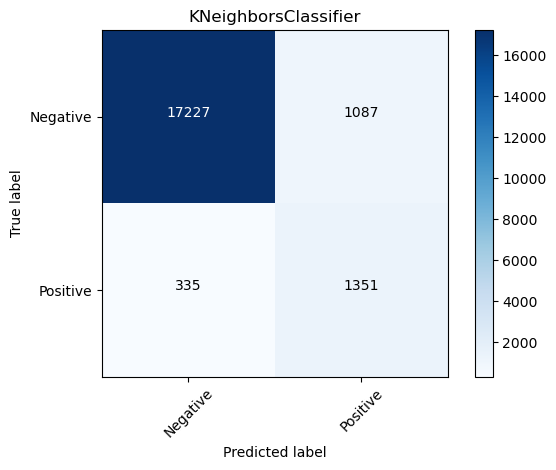

              precision    recall  f1-score   support

    Negative       0.98      0.94      0.96     18314
    Positive       0.55      0.80      0.66      1686

    accuracy                           0.93     20000
   macro avg       0.77      0.87      0.81     20000
weighted avg       0.94      0.93      0.93     20000



In [17]:
from sklearn.neighbors import KNeighborsClassifier

estimator = KNeighborsClassifier(n_neighbors=5)
run_baseline(estimator, X_train, X_test, y_train, y_test)

### Naive Bayes

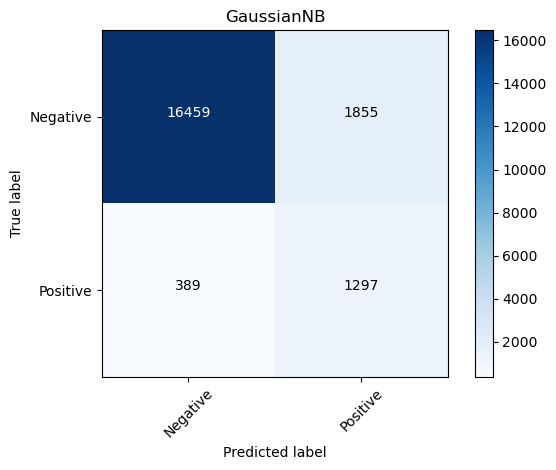

              precision    recall  f1-score   support

    Negative       0.98      0.90      0.94     18314
    Positive       0.41      0.77      0.54      1686

    accuracy                           0.89     20000
   macro avg       0.69      0.83      0.74     20000
weighted avg       0.93      0.89      0.90     20000



In [18]:
from sklearn.naive_bayes import GaussianNB

estimator = GaussianNB()
run_baseline(estimator, X_train, X_test, y_train, y_test)

### Support Vector Machine

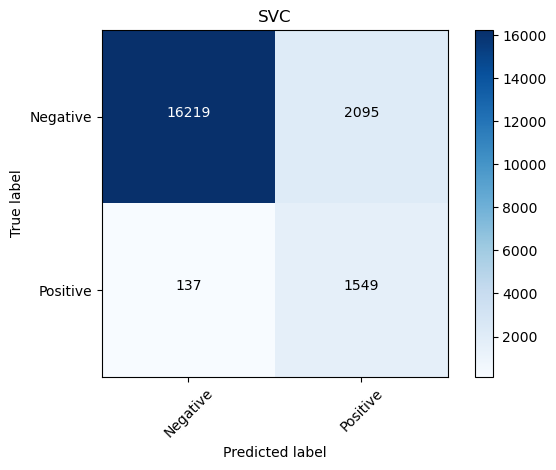

              precision    recall  f1-score   support

    Negative       0.99      0.89      0.94     18314
    Positive       0.43      0.92      0.58      1686

    accuracy                           0.89     20000
   macro avg       0.71      0.90      0.76     20000
weighted avg       0.94      0.89      0.91     20000



In [19]:
from sklearn.svm import SVC

estimator = SVC()
run_baseline(estimator, X_train, X_test, y_train, y_test)

### Neural Network

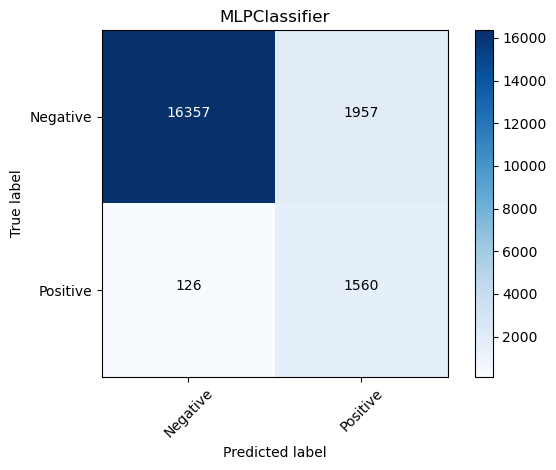

              precision    recall  f1-score   support

    Negative       0.99      0.89      0.94     18314
    Positive       0.44      0.93      0.60      1686

    accuracy                           0.90     20000
   macro avg       0.72      0.91      0.77     20000
weighted avg       0.95      0.90      0.91     20000



In [20]:
from sklearn.neural_network import MLPClassifier

estimator = MLPClassifier()
run_baseline(estimator, X_train, X_test, y_train, y_test)

### FastAI Neural Network

In [21]:
# Fixes the issue with the progress bar in Jupyter notebooks
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

In [22]:
from fastai.tabular.all import *
from pathlib import Path

path = Path(".")

# Define your categorical and continuous variables
cat_vars = ["gender", "hypertension", "heart_disease"]
cont_vars = ["age", "bmi", "HbA1c_level", "blood_glucose_level"]
y_names = "diabetes"
y_block = CategoryBlock()

# Define the preprocessing steps
procs = [Categorify, FillMissing, Normalize]

# Create a TabularDataLoaders object
dls = TabularDataLoaders.from_csv(path/'diabetes_prediction_dataset.csv', path=path, y_names=y_names,
    cat_names=cat_vars, cont_names=cont_vars, procs=procs, bs=2048, y_block=y_block)

# Learn the model
learn = tabular_learner(dls, metrics=F1Score(average="macro"), y_range=(0, 1))
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,f1_score,time
0,0.671010,0.631717,0.614243,00:02
1,0.592855,0.491519,0.718298,00:01
2,0.513600,0.410012,0.819656,00:01
3,0.446851,0.374599,0.865459,00:01
4,0.402621,0.360440,0.876163,00:01
5,0.377472,0.354613,0.878211,00:01
6,0.363808,0.351148,0.885457,00:01
7,0.356391,0.349511,0.884783,00:01
8,0.352590,0.349136,0.886608,00:01
9,0.350663,0.349059,0.887437,00:01


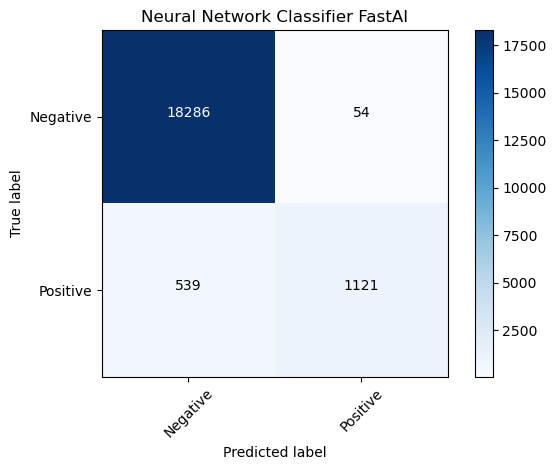

In [23]:
# Get predictions
preds, targets = learn.get_preds(dl=dls.valid)
predicted_classes = preds.argmax(dim=1)

# Plot confusion matrix
cm = confusion_matrix(targets, predicted_classes, labels=label_order)
plot_confusion_matrix(cm, classes=label_names, title="Neural Network Classifier FastAI")
plt.show()

In [24]:
# Report metrics
print(classification_report(targets, predicted_classes))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18340
           1       0.95      0.68      0.79      1660

    accuracy                           0.97     20000
   macro avg       0.96      0.84      0.89     20000
weighted avg       0.97      0.97      0.97     20000

